In [1]:
!pip install requests

In [2]:
# Spam data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from io import StringIO
    
# Downloading the csv file from your GitHub account

# url = "REPLACE-THIS-WITH-THE-URL-OF-THE-CSV-FILE" # Make sure the url is the raw version of the file on GitHub
url = "https://raw.githubusercontent.com/Conero007/Spam-Detection/master/spam.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe

print (df.head())

                                                text target
0  Go until jurong point, crazy.. Available only ...    ham
1                      Ok lar... Joking wif u oni...    ham
2  Free entry in 2 a wkly comp to win FA Cup fina...   spam
3  U dun say so early hor... U c already then say...    ham
4  Nah I don't think he goes to usf, he lives aro...    ham


In [3]:
# Determine data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   target  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# Counting number of spam and ham in the data

target_count = df['target'].value_counts(dropna = False)
target_count

ham     4825
spam     747
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

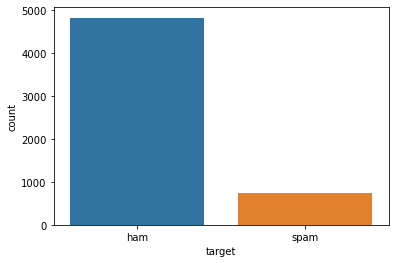

In [5]:
# Bar chart of outcome

import seaborn as sns
sns.countplot(x = 'target', data = df)

In [6]:
# Calculate percentages of spam and ham in the portfolio

count_spam = len([df['target']])
count_ham = len([df['target']])
r=count_spam+count_ham
print(count_spam)
print(count_ham)

1
1


In [7]:
# Checking for duplicates

sum(df.duplicated())

403

In [8]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [9]:
# Preprocessing - select and transform continuous predictors (rescaling / polynomial transform)

numeric_features = []
numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),
                                      ('scaler', StandardScaler())])

In [10]:
# Preprocessing - discrete predictors (one-hot encoding)

categorical_features = ['text', 'target']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [11]:
# Combine both numerical and categorical column using the Column Transformer module

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [12]:
# Define SMOTE and LR algorithm

smt = SMOTE(random_state=42,sampling_strategy= 'minority')
lor = LogisticRegression(C = 50)

In [13]:
# Chain all of the steps using imbalance pipeline module

clf = Pipeline([('preprocessor', preprocessor),('smt', smt),
                ('lor',lor)])

In [14]:
# Test and train split


X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
# Count Vectorizer

vect = CountVectorizer(min_df = 5, ngram_range = (2,5), analyzer = 'char_wb')
vect.fit(X_train)

CountVectorizer(analyzer='char_wb', min_df=5, ngram_range=(2, 5))

In [16]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature
    feature_to_add can also be a list of features
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [17]:
# Transform train data

X_train_vect = vect.transform(X_train)
X_train_vect = add_feature(X_train_vect, [len(x) for x in X_train])
X_train_vect = add_feature(X_train_vect, [sum(char.isnumeric() for char in x) for x in X_train])
X_train_vect = add_feature(X_train_vect, X_train.str.count('\W'))

In [18]:
# Transform test data

X_test_vect = vect.transform(X_test)
X_test_vect = add_feature(X_test_vect, [len(x) for x in X_test])
X_test_vect = add_feature(X_test_vect, [sum(char.isnumeric() for char in x) for x in X_test])
X_test_vect = add_feature(X_test_vect, X_test.str.count('\W'))

In [19]:
# Split the data into test/train
# Fit the training data using chained pipeline - preprocessing steps, imbalance module, LR 

y = df['target']
X= df 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state = 50)
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['text', 'target'])])),
                ('smt', SMOTE(random_state=42, sampling_strategy='minority')),
                ('lor', LogisticRegression(C=50))])

In [20]:
# Compute model accuracy

from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
1.0


In [21]:
clf_predicted = clf.predict(X_test)

In [22]:
# Generate confusion matrix

confusion = confusion_matrix(y_test, clf_predicted)
confusion

array([[954,   0],
       [  0, 161]], dtype=int64)

In [23]:
# Classification Report
# Precision, recall and F1-score of our model.

from sklearn.metrics import classification_report
print(classification_report(y_test, clf_predicted, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



In [24]:
import sklearn.metrics as metrics
probs = clf.predict_proba(X_test)
preds = probs[:,1]
print (classification_report(y_test, clf_predicted, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       161

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



In [25]:
y_test=y_test.replace(['ham','spam'],[0,1])

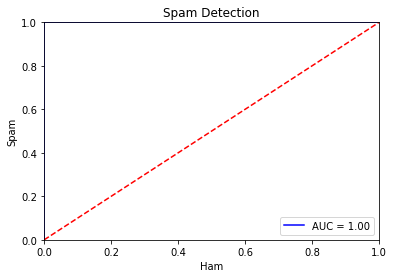

In [26]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold =metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Spam Detection')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Spam')
plt.xlabel('Ham')
plt.show()